In [1]:
import numpy as np
import pandas as pd
import cv2

/var/folders/lt/kx8r1rpd7lbg37j10fbnmvnr0000gn/T/ipykernel_21519/2662070801.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def process_torch_datasets(dataiterator):
    count = 0
    all_dataset = []
    labels = []
    iterator = iter(dataiterator)
    for batch, label_batch in iterator:
        if count < 30:
            for (image, lab) in zip(batch, label_batch):
                img = image.numpy()
                img = img.transpose(1, 2, 0)
                img = (img * 255).astype(np.uint8)
                all_dataset.append(img)
                labels.append(lab)
        count +=1


    return np.array(all_dataset), np.array(labels)

In [3]:
def compute_color_histogram(image_array):

    # Calculate the histograms for each channel
    if image_array.shape[2] == 3:
        hist = cv2.calcHist([image_array], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    else:
        hist = cv2.calcHist([image_array], [0], None, [256], [0, 256])
    
    histogram = cv2.normalize(hist, hist).flatten()

    return histogram


def extract_features(image_array):

    if image_array.shape[2] == 3:
        # Convert the image to grayscale
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

    # Create a SIFT object
    sift = cv2.SIFT_create()

    # Detect and compute SIFT keypoints and descriptors
    kp, des = sift.detectAndCompute(image_array, None)

    return kp, des


In [4]:
import yaml

with open("config.yaml") as cf:
    config_file = yaml.load(cf, Loader=yaml.FullLoader)

In [5]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

if config_file["dataset"].strip().lower() == "cifar10":
    trainset = datasets.CIFAR10("./data", download=True, train=True, transform=transform)
    testset = datasets.CIFAR10("./data", download=True, train=False, transform=transform)

if config_file["dataset"].strip().lower() == "fashionmnist":
    trainset = datasets.FashionMNIST("./data", download=True, train=True, transform=transform)
    testset = datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

In [7]:
train_images, train_labels = process_torch_datasets(train_loader)
test_images, test_labels = process_torch_datasets(test_loader)

In [8]:
algo = cv2.SIFT_create()

def extract_descriptors(images):
    descritpors_batch = []
    for image in images:
        _, des = extract_features(image)
                    
        if des is not None:
            descritpors_batch.append(des)

    descritpors_batch = np.vstack(descritpors_batch)

    return descritpors_batch

In [9]:
descritpors_batch = extract_descriptors(train_images)

In [10]:
from sklearn.cluster import KMeans

def calculate_kmeans(descritpors_batch, n_clusters=100):

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(descritpors_batch)

    return kmeans

In [11]:
kmeans = calculate_kmeans(descritpors_batch, n_clusters=config_file["n_cluster"])

In [12]:
def create_feature_vectors(sift, kmeans, images, labels, n_clusters=100):
    kmeans.verbose = False
    histo_list = []
    color_list = []
    labels_list = []

    for image, label in zip(images, labels):
        hist = compute_color_histogram(image)
        kp, des = sift.detectAndCompute(image,None)

        histo = np.zeros(n_clusters)
        nkp = np.size(kp)
        if des is not None:
            for d in des:
                idx = kmeans.predict(d.reshape(1, -1))
                histo[idx] += 1 / nkp # normalized histograms
        histo_list.append(histo)
        labels_list.append(label)
        color_list.append(hist)

    feature_vector = np.hstack((np.array(histo_list), np.array(color_list)))

    return feature_vector, np.array(labels_list)

In [13]:
X_train, y_train = create_feature_vectors(algo, kmeans, train_images, train_labels, n_clusters=config_file["n_cluster"])

## Preparing test data

In [14]:
test_descritpors_batch = extract_descriptors(test_images)

In [15]:
test_kmeans = calculate_kmeans(test_descritpors_batch, n_clusters=config_file["n_cluster"])

In [16]:
X_test, y_test = create_feature_vectors(algo, test_kmeans, test_images, test_labels, n_clusters=config_file["n_cluster"])

### Training models

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Create a RandomizedSearchCV object
rf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(rf, param_distributions=config_file["param_decision_tree"],
                                   n_iter=10, cv=5)

# Fit the RandomizedSearchCV object to the data
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [5, 10, 7, 25, 50],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 4, 7, 9, 10],
                                        'n_estimators': [50, 150, 200, 500]})

In [18]:
import dataframe_image as dfi

# Print the best hyperparameters and the corresponding score
print('Best hyperparameters for RandomForest:', random_search_rf.best_params_)
print('Best score for RandomForest:', random_search_rf.best_score_)
results_rf = pd.DataFrame(random_search_rf.cv_results_)
results_rf.to_csv("./reports/cv_table_results_for_rf_" + str(config_file["dataset"]) + ".csv")
info_rf = results_rf[["mean_fit_time", "mean_score_time", "params", "mean_test_score"]]
dfi.export(info_rf, "./reports/rf_" + str(config_file["dataset"]) + ".png")
info_rf.head()


Best hyperparameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25}
Best score for RandomForest: 0.5270833333333333


objc[47356]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa44a01aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/110.0.5481.100/Libraries/libGLESv2.dylib (0x115df2220). One of the two will be used. Which one is undefined.
[0225/192143.468152:INFO:headless_shell.cc(107)] 200182 bytes written to file /var/folders/j5/kszwdsbn7_b1d3442mnt7tsh0000gn/T/tmpkmpgq997/temp.png


,mean_fit_time,mean_score_time,params,mean_test_score
0,0.989389,0.013123,"{'n_estimators': 150, 'min_samples_split': 10,...",0.518229
1,0.713691,0.013146,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.504687
2,1.464808,0.018685,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.527083
3,1.792069,0.031721,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.491667
4,0.233604,0.003990,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.494271


In [19]:
from sklearn.svm import SVC

svc = SVC()

random_search_svc = RandomizedSearchCV(svc, param_distributions=config_file["param_svc"],
                                   n_iter=10, cv=5)

random_search_svc.fit(X_train, y_train)

/Users/orahashani/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'kernel': ['rbf', 'linear']})

In [20]:
# Print the best hyperparameters and the corresponding score
print('Best hyperparameters for SVC:', random_search_svc.best_params_)
print('Best score for SVC:', random_search_svc.best_score_)
results_svc = pd.DataFrame(random_search_svc.cv_results_)
results_svc.to_csv("./reports/cv_table_results_for_svc_" + str(config_file["dataset"]) + ".csv")
info_svc = results_svc[["mean_fit_time", "mean_score_time", "params", "mean_test_score"]]
dfi.export(info_svc, "./reports/svc_" + str(config_file["dataset"]) + ".png")
info_svc.head()

Best hyperparameters for SVC: {'kernel': 'rbf'}
Best score for SVC: 0.528125


objc[47377]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa44a01aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/110.0.5481.100/Libraries/libGLESv2.dylib (0x111e72220). One of the two will be used. Which one is undefined.
[0225/192148.602313:INFO:headless_shell.cc(107)] 57151 bytes written to file /var/folders/j5/kszwdsbn7_b1d3442mnt7tsh0000gn/T/tmp31sxi06n/temp.png


,mean_fit_time,mean_score_time,params,mean_test_score
0,0.311625,0.105005,{'kernel': 'rbf'},0.528125
1,0.258879,0.041559,{'kernel': 'linear'},0.514062


In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(knn, param_distributions=config_file["knearest_neighbor_params"],
                                   n_iter=10, cv=5)

random_search_knn.fit(X_train, y_train)

/Users/orahashani/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/orahashani/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/orahashani/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the de

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [3, 5, 7], 'p': [1, 2]})

In [22]:
# Print the best hyperparameters and the corresponding score
print('Best hyperparameters for KNN:', random_search_knn.best_params_)
print('Best score for KNN:', random_search_knn.best_score_)
results_knn = pd.DataFrame(random_search_knn.cv_results_)
results_knn.to_csv("./reports/cv_table_results_for_knn_" + str(config_file["dataset"]) + ".csv")
info_knn = results_knn[["mean_fit_time", "mean_score_time", "params", "mean_test_score"]]
dfi.export(info_knn, "./reports/knn_" + str(config_file["dataset"]) + ".png")
info_knn.head()

Best hyperparameters for KNN: {'p': 2, 'n_neighbors': 5}
Best score for KNN: 0.4244791666666667


objc[47393]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa44a01aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/110.0.5481.100/Libraries/libGLESv2.dylib (0x1139de220). One of the two will be used. Which one is undefined.
[0225/192151.650489:INFO:headless_shell.cc(107)] 113794 bytes written to file /var/folders/j5/kszwdsbn7_b1d3442mnt7tsh0000gn/T/tmp1bs53nm5/temp.png


,mean_fit_time,mean_score_time,params,mean_test_score
0,0.001495,0.106736,"{'p': 1, 'n_neighbors': 3}",0.309375
1,0.000824,0.017957,"{'p': 2, 'n_neighbors': 3}",0.402604
2,0.001071,0.110794,"{'p': 1, 'n_neighbors': 5}",0.292187
3,0.000783,0.020113,"{'p': 2, 'n_neighbors': 5}",0.424479
4,0.000980,0.111125,"{'p': 1, 'n_neighbors': 7}",0.259375


### Training & Evaluating

In [23]:
from sklearn.metrics import confusion_matrix

best_rf = RandomForestClassifier(n_estimators=random_search_rf.best_params_["n_estimators"], max_depth=random_search_rf.best_params_["max_depth"], 
                            min_samples_split=random_search_rf.best_params_["min_samples_split"], min_samples_leaf=random_search_rf.best_params_["min_samples_leaf"])
best_rf.fit(X_train, y_train)

predict_rf = best_rf.predict(X_test)

In [24]:
best_svc = SVC(kernel=random_search_svc.best_params_["kernel"])
best_svc.fit(X_train, y_train)

predict_svc = best_svc.predict(X_test)

In [25]:
best_knn = KNeighborsClassifier(n_neighbors=random_search_knn.best_params_["n_neighbors"], p=random_search_knn.best_params_["p"])
best_knn.fit(X_train, y_train)

predict_knn = best_knn.predict(X_test)

/Users/orahashani/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [26]:
cm_rf = confusion_matrix(y_test, predict_rf, labels=[0,1,2,3,4,5,6,7,8,9])
cm_svc = confusion_matrix(y_test, predict_svc, labels=[0,1,2,3,4,5,6,7,8,9])
cm_knn = confusion_matrix(y_test, predict_knn, labels=[0,1,2,3,4,5,6,7,8,9])

cms = {"random_forest_0": cm_rf, "suport_vector_machine_1": cm_svc, "knearest_neighbor_2": cm_knn}

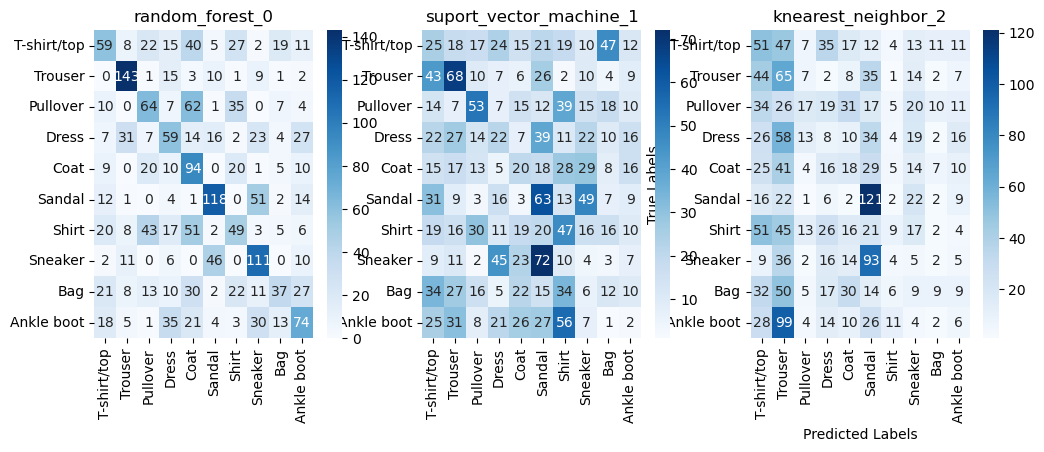

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for key, value in cms.items():
    if config_file["dataset"].strip().lower() == "cifar10":
        sns.heatmap(value, annot=True, fmt='g', cmap='Blues', xticklabels=config_file["cifar10_labels"], yticklabels=config_file["cifar10_labels"], ax=axes[int(key[-1])])
        axes[int(key[-1])].set_title(key) 
    elif config_file["dataset"].strip().lower() == "fashionmnist":
        sns.heatmap(value, annot=True, fmt='g', cmap='Blues', xticklabels=config_file["fashionmnist_labels"], yticklabels=config_file["fashionmnist_labels"],  ax=axes[int(key[-1])])
        axes[int(key[-1])].set_title(key) 



plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()